In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

from os import listdir
from os.path import isfile, join

from tqdm.notebook import tqdm
from numpy.random import default_rng
import pickle

from scipy.stats import gamma, beta

import tensorflow as tf
from functools import partial

c:\Users\Lukas.Schumacher\miniconda3\envs\cogModeling\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
sys.path.append("../src")
from networks_10092022 import *
from priors import diffusion_prior, random_walk_prior
from micro_models import *
from macro_models import random_walk
from context import generate_design_matrix
from plot_funs import *
from transformations import z_standardize

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [4]:
N_SIM = 100
N_OBS = 100
N_SAMPLES = 4000
N_PARAMS = 3

In [5]:
# load simulated data and ture params
sim = pd.read_pickle('../data/sim_data/static_dm_data_100.pkl')
x_nn = sim['rt']
micro_true = sim['theta']
x_nn.shape

(100, 100, 1)

## Prepare dynamic stan posteriors

In [6]:
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [7]:
mypath = "C:/Users/Lukas.Schumacher/Documents/GitHub/dynamic_dm/stan/dynamic_stan_fits"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files.sort(key=natural_keys)
len(files)


100

In [8]:
dynamic_stan_post = np.empty((N_SIM, N_OBS, N_SAMPLES, N_PARAMS))
for i in range(len(files)):
    post_samples = pd.read_csv('dynamic_stan_fits/' + files[i], index_col=False)
    dynamic_stan_post[i] = post_samples.to_numpy()[:, 3:].reshape(100, 4000, 3)

dynamic_stan_post.shape

(100, 100, 4000, 3)

In [9]:
# get mean and std of posterior stds
dynamic_stan_post_std_means = dynamic_stan_post.std(axis=2).mean(axis=0)
dynamic_stan_post_std_stds = dynamic_stan_post.std(axis=2).std(axis=0)

In [10]:
# get posterior means
dynamic_stan_post_means = dynamic_stan_post.mean(axis=2)
dynamic_stan_post_means.shape


(100, 100, 3)

In [11]:
dynamic_stan_abs_error = np.empty((N_SIM, N_OBS, N_PARAMS))
for i in range(N_SIM):
    dynamic_stan_abs_error[i] = np.abs(dynamic_stan_post_means[i] - micro_true[i])
dynamic_stan_abs_error.shape

(100, 100, 3)

In [12]:
dynamic_stan_abs_error_mean = dynamic_stan_abs_error.mean(axis=0)
dynamic_stan_abs_error_std = dynamic_stan_abs_error.std(axis=0)

## Neural Training

In [13]:
def generator_fun(batch_size, T):
#     macro_prior_mean = beta.mean(1, 25)
#     macro_prior_sd = beta.std(1, 25)
#     micro_prior_means = gamma.mean([2.5, 4, 1.5], scale=[1/2, 1/3, 1/5])
#     micro_prior_sds = gamma.std([2.5, 4, 1.5], scale=[1/2, 1/3, 1/5])

    theta = diffusion_prior(batch_size, n_cond=1)
    eta = random_walk_prior(batch_size, 3)
    theta_t = random_walk(theta, eta, T)
    rt = simple_batch_diffusion(theta_t).astype(np.float32)

#     eta_z = z_standardize(eta, macro_prior_mean, macro_prior_sd)
    
#     theta_t_z = theta_t.copy()
#     for i in range(theta_t.shape[0]):
#         theta_t_z[i] =  z_standardize(theta_t[i], micro_prior_means,  micro_prior_sds)

    return eta.astype(np.float32), theta_t.astype(np.float32), rt

In [14]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [21]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            macro_params, micro_params, data = generator() 

            # Forward pass
            macro_params_hat, micro_params_hat = network(data, micro_params)

            # loss computation
            loss_macro = nll(macro_params, macro_params_hat)
            loss_micro = nll(micro_params, micro_params_hat)
            total_loss = loss_macro + loss_micro
        
        # One step backprop
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss.Macro: {:.3f},Loss.Micro: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss_macro.numpy(), loss_micro.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [22]:
network_settings = {
    'embedding_lstm_units' : 512, # increase from 128 to 256
    'embedding_gru_units': 512, # increase from 128 to 256
    'dense_pre_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'dense_micro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'dense_macro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'macro_lstm_units': 512, # increase from 128 to 256
    'n_micro_params': 3,
    'n_macro_params': 3
}
network = DynamicGaussianNetworkFactorized(network_settings)

In [23]:
T = 100
batch_size = 32
simulator = partial(generator_fun, T=T, batch_size=batch_size)
epochs = 50
steps_per_epoch = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [24]:
# losses = []
# for ep in range(1, epochs+1):
#     with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(losses_ep)

In [25]:
# network.save_weights('trained_networks/1_drift_100_factorized')

## Fit dynamic dm to static data

In [26]:
network.load_weights("../trained_networks/1_drift_100_factorized")

In [27]:
# fit model
macro_post, micro_post = network.sample_n(x_nn, N_SAMPLES)
micro_post.shape

TensorShape([4000, 100, 100, 3])

In [ ]:
# micro_prior_means = gamma.mean([2.5, 4, 1.5], scale=[1/2, 1/3, 1/5])
# micro_prior_sds = gamma.std([2.5, 4, 1.5], scale=[1/2, 1/3, 1/5])

In [ ]:
# micro_post_not_z = micro_post.numpy().copy()
# for i in range(micro_post.shape[0]):
#     micro_post_not_z[i] = micro_post[i] * micro_prior_sds + micro_prior_means

In [28]:
# get mean and sd posterior sd's from dynamic model fits
neural_post_std_means = micro_post.numpy().std(axis=0).mean(axis=0)
neural_post_std_stds = micro_post.numpy().std(axis=0).std(axis=0)

In [29]:
neural_post_means = micro_post.numpy().mean(axis=0)
neural_post_means.shape

(100, 100, 3)

In [30]:
neural_abs_error = np.empty((N_SIM, N_OBS, N_PARAMS))
for i in range(N_SIM):
    neural_abs_error[i] = np.abs(neural_post_means[i] - micro_true[i])

neural_abs_error_mean = np.mean(neural_abs_error, axis=0)
neural_stan_abs_error_std = np.std(neural_abs_error, axis=0)

## Plotting

In [31]:
# neural_abs_error_mean = np.load("saved_arrays/neural_abs_error_mean.npy")
# neural_stan_abs_error_std = np.load("saved_arrays/neural_stan_abs_error_std.npy")

# dynamic_stan_abs_error_mean = np.load("saved_arrays/dynamic_stan_abs_error_mean.npy")
# dynamic_stan_abs_error_std = np.load("saved_arrays/dynamic_stan_abs_error_std.npy")

# neural_post_std_means = np.load("saved_arrays/neural_post_std_means.npy")
# neural_post_std_stds = np.load("saved_arrays/neural_post_std_stds.npy")

# dynamic_stan_post_std_means = np.load("saved_arrays/dynamic_stan_post_std_means.npy")
# dynamic_stan_post_std_stds = np.load("saved_arrays/dynamic_stan_post_std_stds.npy")

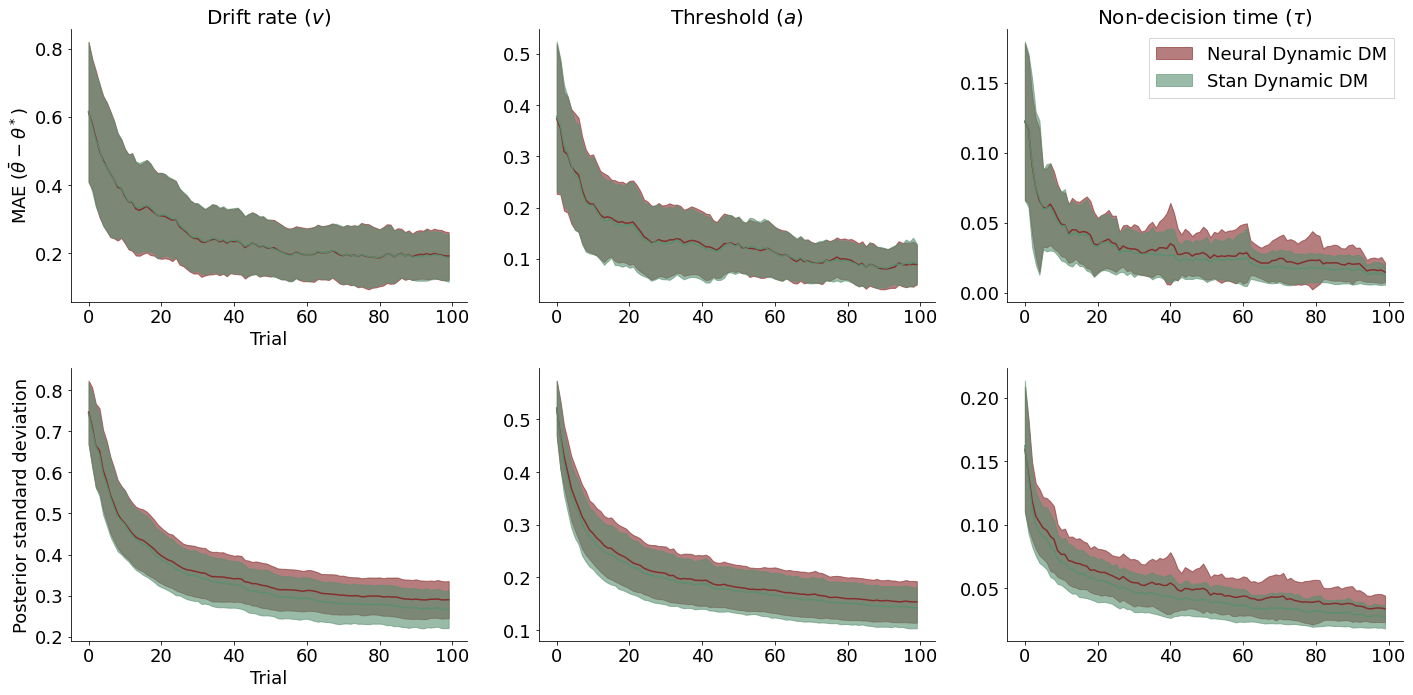

In [32]:
param_labels = ['Drift rate', 'Threshold', 'Non-decision time']
param_names = [r'$v$', r'$a$', r'$\tau$']
time = np.arange(dynamic_stan_post_std_stds.shape[0])
plt.rcParams['font.size'] = 18
ALPHA = 0.6
f, axarr = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axarr.flat):
    if i < 3:
        # plot neural results
        ax.plot(time, neural_abs_error_mean[:, i], alpha=0.9, color='#852626')
        ax.fill_between(time, neural_abs_error_mean[:, i] - neural_stan_abs_error_std[:, i]/2, neural_abs_error_mean[:, i] + neural_stan_abs_error_std[:, i]/2,
                        alpha=ALPHA, label='Neural Dynamic DM', color='#852626')

        # plot dynamic stan
        ax.plot(time, dynamic_stan_abs_error_mean[:, i], alpha=0.9, color='#598f70')
        ax.fill_between(time, dynamic_stan_abs_error_mean[:, i] - dynamic_stan_abs_error_std[:, i]/2, dynamic_stan_abs_error_mean[:, i] + dynamic_stan_abs_error_std[:, i]/2,
                        alpha=ALPHA, label='Stan Dynamic DM', color='#598f70')

        ax.set_title(param_labels[i] + ' ({})'.format(param_names[i]), fontsize=20)

        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel(r'MAE $(\bar{\theta} - \theta^*)$', fontsize=18)
        if i == 2:
            ax.legend(fontsize=18, loc='best', fancybox=False, shadow=False)

    else:
        # plot neural results
        ax.plot(time, neural_post_std_means[:, i-3], alpha=0.9, color='#852626')
        ax.fill_between(time, neural_post_std_means[:, i-3]+neural_post_std_stds[:, i-3]/2, neural_post_std_means[:, i-3]-neural_post_std_stds[:, i-3]/2,
                        alpha=ALPHA, label='Neural Dynamic DM', color='#852626')

        # plot dynamic stan
        ax.plot(time, dynamic_stan_post_std_means[:, i-3], alpha=0.9, color='#598f70')
        ax.fill_between(time, dynamic_stan_post_std_means[:, i-3]+dynamic_stan_post_std_stds[:, i-3]/2, dynamic_stan_post_std_means[:, i-3]-dynamic_stan_post_std_stds[:, i-3]/2,
                        alpha=ALPHA, label='Stan Dynamic DM', color='#598f70')
        
        
        if i == 3:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel('Posterior standard deviation', fontsize=18)

    # ax.grid(alpha=0.3)

sns.despine()
plt.tight_layout()
plt.savefig('plot_stan_benchmark.png', dpi=300)